In [1]:
# project: p5
# submitter: pjfife
# partner: none
# hours: 7.5

In [2]:
import os
import zipfile
import pandas as pd
import edgar_utils as ed
import zipfile
import time
from graphviz import Digraph
from collections import Counter
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

In [3]:
df = pd.read_csv('server_log.zip', compression = 'zip')

## Q1: what's the total size in bytes of the files requested?

In [4]:
#Q1
int(df['size'].sum())

24801002666

## Q2: how many filings have been accessed by the top ten IPs?


In [5]:
#Q2
t10 = df.value_counts('ip').head(10).to_dict()
t10

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

## Q3: what fraction of the requests had errors?

In [6]:
#Q3
len(df[df['code'] >= 400]) / len(df)

0.03466852724527611

## Q4: what is the most frequently accessed file?

In [7]:
#Q4
df['cik'] = df['cik'].astype(int)
df['file'] = df['cik'].astype(str) + '/' + df['accession'] + '/' + df['extention']
df['file'].value_counts().idxmax()


'1627631/0001627631-15-000004/.txt'

## Q5: how many requests were made by automated crawlers?

In [8]:
#Q5
len(df[df['crawler'] == 1])

971

In [9]:
##KEEP

regions = []

for ip in df['ip']:
    region = ed.lookup_region(ip)
    regions.append(region)
    
df['region'] = regions
df

,ip,date,time,zone,cik,accession,extention,code,size,idx,norefer,noagent,find,crawler,browser,file,region
0,104.197.32.ihd,2017-01-01,00:00:00,0.0,1111711,0001193125-12-324016,-index.htm,200.0,7627.0,1.0,0.0,0.0,10.0,0.0,NaN,1111711/0001193125-12-324016/-index.htm,United States of America
1,208.77.214.jeh,2017-01-01,00:00:00,0.0,789019,0001193125-06-031505,.txt,200.0,46327.0,0.0,0.0,0.0,10.0,0.0,NaN,789019/0001193125-06-031505/.txt,United States of America
2,54.197.228.dbe,2017-01-01,00:00:00,0.0,800166,0001279569-16-003038,-index.htm,200.0,16414.0,1.0,0.0,0.0,10.0,0.0,NaN,800166/0001279569-16-003038/-index.htm,United States of America
3,108.39.205.jga,2017-01-01,00:00:01,0.0,354950,0000950123-09-011236,-index.htm,200.0,8718.0,1.0,0.0,0.0,10.0,0.0,NaN,354950/0000950123-09-011236/-index.htm,United States of America
4,52.45.218.ihf,2017-01-01,00:00:01,0.0,1313918,0001209191-06-031555,.txt,200.0,8911.0,0.0,0.0,0.0,10.0,0.0,NaN,1313918/0001209191-06-031555/.txt,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174851,218.50.187.afh,2017-01-01,23:59:56,0.0,1295803,0001181431-07-073286,.txt,200.0,29312.0,0.0,0.0,0.0,10.0,0.0,NaN,1295803/0001181431-07-073286/.txt,Korea (Republic of)
174852,204.212.175.bch,2017-01-01,23:59:57,0.0,89439,0001140361-14-029415,.txt,200.0,2165.0,0.0,0.0,0.0,10.0,0.0,NaN,89439/0001140361-14-029415/.txt,United States of America
174853,157.55.39.jad,2017-01-01,23:59:58,0.0,1253986,0001104659-12-032900,a12-8801_1ex31d2.htm,301.0,630.0,0.0,0.0,0.0,10.0,0.0,NaN,1253986/0001104659-12-032900/a12-8801_1ex31d2.htm,United States of America
174854,94.156.218.jad,2017-01-01,23:59:58,0.0,1591913,0001615774-16-009113,-index.htm,200.0,7037.0,1.0,0.0,0.0,10.0,0.0,NaN,1591913/0001615774-16-009113/-index.htm,Bulgaria


## Q6: which region uses EDGAR most heavily?

In [10]:
#Q6
df['region'].mode()[0]

'United States of America'

In [11]:
#Q7
hv_dict = {}

c1k = df.value_counts('region')[df.value_counts('region') > 1000].to_dict().keys()

for country in c1k:
    unique_ips = df[df['region'] == country]['ip'].unique()
    ip_count = len(unique_ips)
    ips_num = df[df['region'] == country]['ip'].value_counts()
    ips_1k = len(ips_num[ips_num > 1000])
    hv_dict[country] = ips_1k / ip_count
    
for country in df['region'].unique():
    if country in hv_dict:
        continue
    else:
        hv_dict[country] = 0.0
        
hv_dict

{'United States of America': 0.019862490450725745,
 'China': 0.006864988558352402,
 'Ireland': 0.3125,
 'United Kingdom of Great Britain and Northern Ireland': 0.06666666666666667,
 'India': 0.058823529411764705,
 'Korea (Republic of)': 0.2,
 'Canada': 0.017857142857142856,
 'France': 0.0036900369003690036,
 'Germany': 0.0,
 'Bulgaria': 0.3333333333333333,
 'Australia': 0.07692307692307693,
 'Hong Kong': 0.0,
 'Czechia': 0.0,
 'Spain': 0.0,
 'Netherlands': 0.0,
 'Sweden': 0.0,
 'Sudan': 0.0,
 'Estonia': 0.0,
 'Russian Federation': 0.0,
 'Tanzania, United Republic of': 0.0,
 'Yemen': 0.0,
 'Algeria': 0.0,
 'Ukraine': 0.0,
 'Slovakia': 0.0,
 'Viet Nam': 0.0,
 'Denmark': 0.0,
 'Singapore': 0.0,
 'Switzerland': 0.0,
 'Thailand': 0.0,
 'South Africa': 0.0,
 'Italy': 0.0,
 'Poland': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Brazil': 0.0,
 'Morocco': 0.0,
 'Malaysia': 0.0,
 'Hungary': 0.0,
 'Japan': 0.0,
 'Luxembourg': 0.0,
 'Romania': 0.0,
 'Liberia': 0.0,
 'Israel': 0.0,
 'Bangladesh': 0.0

## Q7: what fraction of IPs in each region are high-volume users?

In [12]:
##KEEP
zip_file = zipfile.ZipFile('docs.zip','r')
filings = {}

for name in zip_file.namelist():
    if name[-3:] == "htm" or name[-4:] == "html":
        with zipfile.ZipFile('docs.zip', 'r') as myzip:
            with myzip.open(name) as myfile:
                html = myfile.read()
                filings[name] = ed.Filing(html.decode("utf-8"))

## Q8: what dates appear in the 850693/0000850693-07-000159/-index.htm file of docs.zip?

In [13]:
#Q8
filings["850693/0000850693-07-000159/-index.htm"].dates

['2007-07-25', '2007-07-25', '2007-07-23']

## Q9: what is the distribution of states for the filings in docs.zip?

In [14]:
#Q9
states = {}

for file in filings:
    state = filings[file].state()
    if state == None:
        continue
    if state in states:
        states[state] += 1
    else:
        states[state] = 1

states

{'OX': 6,
 'NJ': 23,
 'MS': 1,
 'MA': 30,
 'CA': 91,
 'CO': 25,
 'NY': 83,
 'TX': 64,
 'FL': 21,
 'AL': 1,
 'IN': 4,
 'CT': 14,
 'UT': 5,
 'MD': 13,
 'KS': 5,
 'VA': 15,
 'OH': 10,
 'SD': 1,
 'DE': 10,
 'IL': 25,
 'GA': 8,
 'NC': 9,
 'PA': 25,
 'TN': 4,
 'MN': 15,
 'NM': 1,
 'KY': 2,
 'OK': 7,
 'AR': 1,
 'NV': 6,
 'VT': 1,
 'MO': 4,
 'MI': 11,
 'NE': 2,
 'IA': 6,
 'AZ': 5,
 'WI': 9,
 'LA': 2,
 'ID': 1,
 'OR': 2,
 'WV': 2,
 'WA': 3,
 'DC': 1,
 'ME': 1}

## Q10: what is the distribution of SIC codes for the filings in docs.zip?

In [15]:
#Q10
sics = {}

for file in filings:
    sic = filings[file].sic
    if sic == None:
        continue
    if sic in sics:
        sics[sic] += 1
    else:
        sics[sic] = 1

sics

{2834: 40,
 6022: 20,
 1311: 20,
 6189: 17,
 6211: 17,
 8731: 2,
 1389: 19,
 7370: 7,
 3571: 1,
 7361: 1,
 3674: 5,
 4931: 5,
 1040: 2,
 2810: 2,
 7389: 11,
 3140: 1,
 7374: 4,
 6200: 1,
 7381: 1,
 3620: 3,
 3841: 6,
 4941: 1,
 5621: 1,
 7330: 1,
 6199: 8,
 6798: 20,
 2510: 4,
 3990: 2,
 1700: 5,
 7371: 6,
 5940: 2,
 4522: 5,
 1731: 2,
 6311: 2,
 8082: 2,
 2836: 13,
 6021: 20,
 1000: 11,
 4911: 8,
 6324: 2,
 8051: 1,
 6035: 4,
 3550: 1,
 4813: 4,
 6321: 2,
 2890: 1,
 3845: 2,
 2860: 8,
 1221: 2,
 3669: 2,
 6411: 1,
 5900: 2,
 2320: 1,
 6221: 3,
 6331: 10,
 2070: 1,
 8742: 5,
 3829: 3,
 900: 5,
 5500: 2,
 7372: 11,
 6770: 1,
 4841: 2,
 4833: 1,
 7384: 1,
 6799: 3,
 3826: 5,
 8711: 2,
 5160: 1,
 5944: 1,
 3420: 3,
 3510: 3,
 5960: 1,
 3842: 4,
 8062: 3,
 6029: 11,
 7320: 1,
 5172: 2,
 1382: 2,
 3663: 4,
 1400: 3,
 7822: 1,
 2024: 1,
 2080: 1,
 7812: 2,
 4922: 2,
 2030: 1,
 3576: 3,
 2711: 1,
 3578: 1,
 3679: 2,
 2842: 1,
 4899: 1,
 100: 1,
 3541: 1,
 7311: 1,
 3317: 1,
 2033: 1,
 3721: 1

## Q11: what is the distribution of requests across industries?

In [16]:
zip_file = zipfile.ZipFile('docs.zip','r')
files_tocheck = []

for name in zip_file.namelist():
    if name[-3:] == "htm" or name[-4:] == "html" or name[-3:] == "txt":
        files_tocheck.append(name)

In [17]:
#Q11
reqs = {}

for file in df['file']:
    if file in zip_file.namelist():
        sic = filings[file].sic
        if sic == None:
            continue
        if sic in reqs:
            reqs[sic] += 1
        else:
            reqs[sic] = 1
            
reqs

{4931: 70,
 1000: 273,
 6021: 204,
 7371: 229,
 2860: 226,
 6211: 237,
 2834: 984,
 1389: 656,
 4522: 22,
 6282: 171,
 6022: 379,
 1700: 31,
 6331: 91,
 4813: 4,
 2836: 429,
 3620: 50,
 1311: 550,
 4841: 108,
 3272: 81,
 7200: 94,
 6513: 38,
 7374: 94,
 3510: 66,
 4512: 42,
 3826: 56,
 3678: 4,
 4911: 8,
 2510: 171,
 6798: 90,
 7830: 62,
 3571: 6,
 6221: 85,
 3621: 38,
 3695: 55,
 3590: 24,
 6321: 21,
 4812: 4,
 3312: 31,
 3842: 87,
 2870: 2,
 4955: 23,
 7370: 39,
 1040: 2,
 900: 39,
 4833: 7,
 6029: 83,
 3990: 34,
 5311: 90,
 5944: 33,
 3663: 23,
 8742: 27,
 5621: 99,
 8090: 32,
 4412: 43,
 8731: 25,
 7373: 48,
 8711: 2,
 6411: 3,
 3669: 2,
 5172: 36,
 3825: 164,
 3559: 20,
 2080: 1,
 3541: 1,
 7389: 26,
 2711: 1,
 7812: 25,
 7350: 1,
 1400: 3,
 5900: 35,
 3829: 73,
 5812: 19,
 3845: 2,
 6770: 2,
 3841: 14,
 7990: 1,
 2911: 1,
 6799: 46,
 1382: 2,
 3679: 5,
 3721: 1,
 5122: 34,
 5990: 1,
 1531: 4,
 5731: 1,
 5531: 1,
 6324: 30,
 2750: 1,
 4213: 35,
 1381: 31,
 2030: 1,
 3714: 1,
 7372

## Q12: how many requests were made in each hour?

In [18]:
#Q12
df['dt'] = pd.to_datetime(df['time'])

hours_list = []
for time in df['dt']:
    hours_list.append(time.hour)
hours_list

df['hour'] = hours_list
hourly = df['hour'].value_counts().to_dict()
hourly

{9: 11033,
 5: 9783,
 3: 8850,
 2: 8550,
 4: 8343,
 0: 8305,
 8: 8292,
 1: 8242,
 7: 8213,
 6: 7761,
 14: 6654,
 15: 6512,
 17: 6487,
 11: 6435,
 10: 6377,
 18: 6356,
 23: 6283,
 19: 6211,
 21: 6164,
 12: 6155,
 22: 6098,
 20: 6066,
 13: 6006,
 16: 5680}

## Q14: what are the most commonly seen street addresses?


In [20]:
#Q14
addys = {}
addys_225 = {}

for file in df['file']:
    if file in zip_file.namelist():
        for address in filings[file].addresses:
            if address == None:
                continue
            if address in addys:
                addys[address] += 1
            else:
                addys[address] = 1
                
for ad in addys:
    count = addys[ad]
    if count > 224:
        addys_225[ad] = count
            
addys_225

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277}

## Q15: geographic plotting of headquarters

<AxesSubplot:>

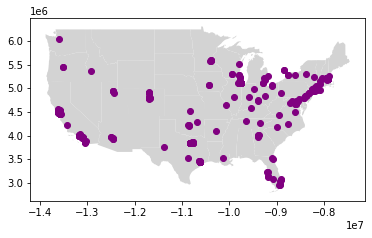

In [21]:
#Q15
us = gpd.read_file("shapes/cb_2018_us_state_20m.shp")#.to_crs("epsg:3395")
df = gpd.read_file("locations.geojson")#.to_crs(us.crs)

window = box(-130, 20, -55, 50)
us = us.intersection(window)
us = us[~us.is_empty].to_crs("epsg:3395")
df = df.intersection(window)
df = df[~df.is_empty].to_crs(us.crs)


ax = us.plot(color = "lightgray")
df.plot(ax=ax, color = "purple")